## Data Cleaning

Steps for data cleaning 
 * load data sets
 * import additional data sets:
     * census population data from [Kaggle dataset](https://www.kaggle.com/peretzcohen/2019-census-us-population-data-by-state)
     * **vaccine data?**
 * convert dates to datetime objects 
 * uniformize time differences to match daily reporting 
 * restrict to contiguous US States and DC
 * handle NaNs? 
 * create proportions, daily differences, and rolling averages for Covid measures  
 * save cleaned data to `data/` folder
 
**What other cleaning/processing do we want to do with this data?**

In [1]:
# pandas and numpy for working with data
import pandas as pd 
import numpy as np

# seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import daily reports by state 
daily_reports = pd.read_csv("../data/csse_covid_19_daily_reports_us.csv")
daily_reports.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate
0,Alabama,US,2021-01-02 05:30:44,32.3182,-86.9023,365747,4872,202137.0,158738.0,1.0,7459.375895,1885216.0,NaN,1.332068,84000001.0,USA,38448.804196,NaN,NaN,NaN
1,Alaska,US,2021-01-02 05:30:44,61.3707,-152.4044,46986,206,7165.0,39615.0,2.0,6422.844801,1275750.0,NaN,0.438428,84000002.0,USA,174391.185778,NaN,NaN,NaN
2,American Samoa,US,2021-01-02 05:30:44,-14.2710,-170.1320,0,0,NaN,0.0,60.0,0.000000,2140.0,NaN,NaN,16.0,ASM,3846.084722,NaN,NaN,NaN
3,Arizona,US,2021-01-02 05:30:44,33.7298,-111.4312,530267,9015,76934.0,444318.0,4.0,7285.171274,5155330.0,NaN,1.700087,84000004.0,USA,39551.860582,NaN,NaN,NaN
4,Arkansas,US,2021-01-02 05:30:44,34.9697,-92.3731,229442,3711,199247.0,26484.0,5.0,7602.945718,2051488.0,NaN,1.617402,84000005.0,USA,67979.497674,NaN,NaN,NaN


## Restricting to the Continental Unites States 

To analyze the transmission of COVID between regions in the US and consider the effects of neighboring regions we first restrict the data to regions in the Continental US. 

The daily reports data reports COVID numbers for all 50 states, plus the District of Columbia, several US territories (e.g. Guam, Puerto Rico) and two cruise ships (Diamond Princess and Grand Princess). The following cell selects only the data associated with the 48 continental US states and the District of Columbia (D.C.). 

In [3]:
# show all provinces/states included in data set
daily_reports['Province_State'].unique()

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'Diamond Princess', 'District of Columbia', 'Florida', 'Georgia',
       'Grand Princess', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virgin Islands', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Recovered'], dtype=object)

In [4]:
# the following are the provinces/states to exclude 
excluded_regions = ['Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands', 'American Samoa', # territories
                    'Diamond Princess', 'Grand Princess', 'Guam', 'Recovered', # other 
                    'Alaska', 'Hawaii'] # non continuous states
# this creates a list of the continental US states and DC in the list 
continguous_US = list(set(list(daily_reports['Province_State'].unique())) - set(excluded_regions))
assert len(continguous_US) == 49 # 50 states + DC - Hawaii, Alaska

# create a dataframe with only data for these continental regions 
cont_daily_reports = daily_reports[daily_reports['Province_State'].isin(continguous_US)]
assert (set(cont_daily_reports['Province_State'].unique()) == set(continguous_US))

## Examine Columns

In [5]:
#check data type for date
cont_daily_reports.dtypes

Province_State           object
Country_Region           object
Last_Update              object
Lat                     float64
Long_                   float64
Confirmed                 int64
Deaths                    int64
Recovered               float64
Active                  float64
FIPS                    float64
Incident_Rate           float64
Total_Test_Results      float64
People_Hospitalized     float64
Case_Fatality_Ratio     float64
UID                     float64
ISO3                     object
Testing_Rate            float64
Hospitalization_Rate    float64
People_Tested           float64
Mortality_Rate          float64
dtype: object

The `Last_Update` column contains a date but is stored as an object, we convert this to DateTime to work with the data as a date. The documentation states that this value represents a date and time in UTC. 

In [6]:
cont_daily_reports.loc[:,'Last_Update'] = pd.to_datetime(cont_daily_reports['Last_Update'], utc=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
## Country_Region
display(cont_daily_reports['Country_Region'].value_counts())
display(cont_daily_reports['ISO3'].value_counts())

US    17346
Name: Country_Region, dtype: int64

USA    17346
Name: ISO3, dtype: int64

In [8]:
# for each province_state count the unique FIPS and UID associated with it and return summary of those counts
display(cont_daily_reports[['Province_State','FIPS']].groupby('Province_State').nunique().value_counts())
display(cont_daily_reports[['Province_State','UID']].groupby('Province_State').nunique().value_counts())

FIPS
1       49
dtype: int64

UID
1      49
dtype: int64

Since all values are the same in this dataset for `Country_Region` and `ISO3`, we can drop these columns. Observe there is exactly one FIPS and UID per Province_State in our dataframe, this data is redundant and can be removed from our dataframe without loss of information. 

In [9]:
cont_daily_reports = cont_daily_reports.drop(columns=['Country_Region','ISO3','FIPS','UID'])
cont_daily_reports.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate
0,Alabama,2021-01-02 05:30:44+00:00,32.3182,-86.9023,365747,4872,202137.0,158738.0,7459.375895,1885216.0,NaN,1.332068,38448.804196,NaN,NaN,NaN
3,Arizona,2021-01-02 05:30:44+00:00,33.7298,-111.4312,530267,9015,76934.0,444318.0,7285.171274,5155330.0,NaN,1.700087,39551.860582,NaN,NaN,NaN
4,Arkansas,2021-01-02 05:30:44+00:00,34.9697,-92.3731,229442,3711,199247.0,26484.0,7602.945718,2051488.0,NaN,1.617402,67979.497674,NaN,NaN,NaN
5,California,2021-01-02 05:30:44+00:00,36.1162,-119.6816,2365024,26363,NaN,2309915.0,5912.603297,33058311.0,NaN,1.125160,83666.036710,NaN,NaN,NaN
6,Colorado,2021-01-02 05:30:44+00:00,39.0598,-105.3111,337161,4873,18102.0,314186.0,5854.774381,4444206.0,NaN,1.445304,77173.289416,NaN,NaN,NaN


**FINISH ANALYSIS OF OTHER COLUMNS HERE** 

create lists for numerics of interest (`covid_metrics`) 

how many NANs are there in each column?? 

Next let's examine the frequency of null values in the remaining data. Below we compute the percentage of null values for each column. 

In [10]:
cont_daily_reports.isna().sum().sort_values()*100/cont_daily_reports.shape[0]

Province_State           0.000000
Last_Update              0.000000
Lat                      0.000000
Long_                    0.000000
Confirmed                0.000000
Deaths                   0.000000
Incident_Rate            0.000000
Testing_Rate             0.000000
Active                   7.062147
Recovered               23.037011
People_Tested           40.395480
Mortality_Rate          40.395480
Total_Test_Results      59.604520
Case_Fatality_Ratio     59.604520
People_Hospitalized     71.711057
Hospitalization_Rate    71.711057
dtype: float64

Let's check if there are any differences by state. Below we create a function that takes a dataframe (will be a group) and computes null percentages for each column in the dataframe. We then apply this as an aggregating function to the dataframe grouped by `Province_State` to get null percentages of each column by region. For columns with no nulls, this will not vary by state so these can be excluded. 

In [11]:
def compute_null_percentage(data):
    return data.isna().sum().sort_values()*100/data.shape[0]

In [12]:
null_percents_by_state = cont_daily_reports.groupby('Province_State').agg(compute_null_percentage).sort_index()
null_percents_by_state.loc[:,null_percents_by_state.any()]

,Recovered,Active,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,Hospitalization_Rate,People_Tested,Mortality_Rate
Province_State,,,,,,,,
Alabama,16.949153,7.062147,59.60452,61.016949,59.60452,61.016949,40.39548,40.39548
Arizona,11.016949,7.062147,59.60452,61.299435,59.60452,61.299435,40.39548,40.39548
Arkansas,7.062147,7.062147,59.60452,61.299435,59.60452,61.299435,40.39548,40.39548
California,98.587571,7.062147,59.60452,95.480226,59.60452,95.480226,40.39548,40.39548
Colorado,14.124294,7.062147,59.60452,61.016949,59.60452,61.016949,40.39548,40.39548
Connecticut,15.819209,7.062147,59.60452,61.864407,59.60452,61.864407,40.39548,40.39548
Delaware,19.774011,7.062147,59.60452,95.480226,59.60452,95.480226,40.39548,40.39548
District of Columbia,7.062147,7.062147,59.60452,95.762712,59.60452,95.762712,40.39548,40.39548
Florida,98.587571,7.062147,59.60452,61.016949,59.60452,61.016949,40.39548,40.39548


From the table above we see that for some metrics, such as `Total_Test_Results`, the amount of missing data is very consistent regardless of region. This might be due to a change in reporting over time (i.e. the metric might have been added part of the way through the date range, with nulls backfilled for previous dates). Let's restrict our attention to those values that less consistent. 

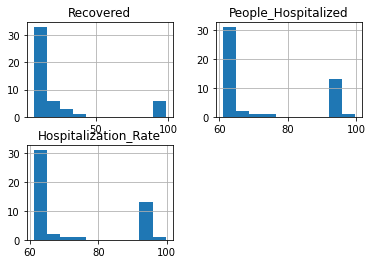

In [13]:
null_percents_by_state.loc[:,null_percents_by_state.std()>0.001].hist();

For each of the three variables we see two groups of values for the null percentages. 

**DO MORE WITH THIS?** 

    People_Hospitalized - Total number of people hospitalized. (Nullified on Aug 31, see Issue #3083)

Does this mean the missing data is from after Aug 31? 

## Uniformizing Timeseries Differences

For analyzing the spread of COVID in time we first want to ensure that the data are regularly distributed in time. In the next few cells we will see that for the most part, there is one entry per Province_State.

Since this data is reported daily, we expect to see one row per Province_State per day. Indeed looking at a few rows from California seems to align with this. 

In [14]:
cont_daily_reports[cont_daily_reports['Province_State']=='California'].sort_values('Last_Update').head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate
5224,California,2020-04-12 23:18:15+00:00,36.1162,-119.6816,22805,640,NaN,22155.0,58.137726,NaN,5234.0,NaN,485.423869,22.961176,190328.0,2.812020
5284,California,2020-04-13 23:07:54+00:00,36.1162,-119.6816,23946,714,NaN,23217.0,61.035048,NaN,3015.0,NaN,486.836823,12.598721,190882.0,2.987756
5343,California,2020-04-14 23:33:31+00:00,36.1162,-119.6816,25373,767,NaN,24589.0,64.669453,NaN,5163.0,NaN,515.723328,20.362044,202208.0,3.028869
5402,California,2020-04-15 22:56:51+00:00,36.1162,-119.6816,26699,860,NaN,25826.0,68.061564,NaN,5163.0,NaN,552.138790,19.347223,216486.0,3.226411
5461,California,2020-04-16 23:30:51+00:00,36.1162,-119.6816,27687,956,NaN,26721.0,70.589069,NaN,5031.0,NaN,628.433237,18.177548,246400.0,3.457745


However if we extract just the date from the `Last_Update` and look at the differences between sequential rows (once ordered by date), we see there are many cases of a 2 day jump and 1 instance of two reports on a single day. 

In [15]:
# extract date only from UTC datetime
cont_daily_reports['UTC_Date_Last_Update'] = cont_daily_reports['Last_Update'].dt.date

In [16]:
def compute_day_diffs(data, date_col):
    '''
    This function takes a dataframe with a date column and returns the 
    dataframe with an additional 
    '''
    # sort by the given date column
    sorted_data = data.sort_values(date_col)
    # take sequential differences and relabel column to 'Days_Diff', note first entry will be NaT
    day_diffs = sorted_data[[date_col]].diff().rename(columns={date_col:'Days_Diff'})
    # merge back into initial data 
    sorted_data = sorted_data.merge(day_diffs, how="inner", left_index=True, right_index=True)
    return sorted_data

def extract_unusual_daily_diffs(data, date_col):
    daily_diff_data = compute_day_diffs(data, date_col)
    # select only rows that are not of daily frequency or the first row (always NaT/Na)
    unusual_date_diffs = daily_diff_data[(daily_diff_data['Days_Diff']!=pd.Timedelta('1D')) & (~ daily_diff_data['Days_Diff'].isna())]
    return unusual_date_diffs

unusual_date_diff_data = cont_daily_reports.groupby('Province_State').apply(extract_unusual_daily_diffs, 
                                                                            date_col='UTC_Date_Last_Update')
unusual_date_diff_data = unusual_date_diff_data.set_index(unusual_date_diff_data.index.droplevel('Province_State'))
unusual_date_diff_data[['Province_State','Last_Update','UTC_Date_Last_Update','Days_Diff']].head()


,Province_State,Last_Update,UTC_Date_Last_Update,Days_Diff
5869,Alabama,2020-04-24 03:33:00+00:00,2020-04-24,"2 days, 0:00:00"
5872,Arizona,2020-04-24 03:33:00+00:00,2020-04-24,"2 days, 0:00:00"
5873,Arkansas,2020-04-24 03:33:00+00:00,2020-04-24,"2 days, 0:00:00"
5874,California,2020-04-24 03:33:00+00:00,2020-04-24,"2 days, 0:00:00"
5875,Colorado,2020-04-24 03:33:00+00:00,2020-04-24,"2 days, 0:00:00"


In [17]:
unusual_date_diff_data[['Days_Diff']].value_counts()

Days_Diff
2 days       50
0 days        1
dtype: int64

From the tables above we see there are 50 2 day jumps and also a single 0 day jump (2 reports on the same day). The next few cells will investigate this further. Using the dates from the unusual rows we can look at the data around that time to see what is going on. 

In [18]:
def data_between_dates(data, date_col, start_date='2020-01-01', end_date='2021-04-03'):
    '''Takes a dataframe and a date column and returns rows where the date column lies between given dates'''
    return data[(data[date_col] >= pd.to_datetime(start_date)) & (data[date_col] <= pd.to_datetime(end_date))]

In [19]:
data_between_dates(cont_daily_reports[cont_daily_reports['Province_State'].isin(['California','New York'])],
                   date_col = 'UTC_Date_Last_Update', start_date = '2020-04-22', end_date = '2020-04-25').sort_values('Province_State')

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,UTC_Date_Last_Update
5815,California,2020-04-22 23:40:26+00:00,36.1162,-119.6816,37731,1421,NaN,35923.0,95.244362,NaN,4984.0,NaN,1186.797699,13.346187,465327.0,3.805163,2020-04-22
5874,California,2020-04-24 03:33:00+00:00,36.1162,-119.6816,39946,1533,NaN,38028.0,100.898731,NaN,4929.0,NaN,1229.568906,12.459240,482097.0,3.875028,2020-04-24
5933,California,2020-04-25 06:32:46+00:00,36.1162,-119.6816,41803,1621,NaN,39734.0,105.474255,NaN,4880.0,NaN,1260.368256,11.800266,494173.0,3.919720,2020-04-25
5846,New York,2020-04-22 23:40:26+00:00,42.1657,-74.9481,263292,19413,23887.0,243879.0,1561.542077,NaN,57103.0,NaN,3973.554395,21.688088,669982.0,7.373183,2020-04-22
5905,New York,2020-04-24 03:33:00+00:00,42.1657,-74.9481,263460,20973,23887.0,242487.0,1562.538458,NaN,57103.0,NaN,4127.388459,21.674258,695920.0,7.960601,2020-04-24
5964,New York,2020-04-25 06:32:46+00:00,42.1657,-74.9481,271590,21411,23887.0,250179.0,1610.756167,NaN,57103.0,NaN,4333.402032,21.025443,730656.0,7.883575,2020-04-25


We see above that the times for the reports changes significantly from around 23:30 UTC (almost midnight) to 3:30-6:30 UTC (early morning) between April 22, 2020 and April 24, 2020. Reviewing the [documentation](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data#time-series-summary-csse_covid_19_time_series), there is the following note: 

    Files on and after April 23, once per day between 03:30 and 04:00 UTC.
    Files from February 2 to April 22: once per day around 23:59 UTC.
    
Since the times are in UTC, but the data is being reported for US states, an early morning UTC time actually corresponds to a time _the previous day_ in the US. So the missing April 23rd data is actually the April 24th data. Each province/state is probably encountering the same time change issue, accounting for 49 (number of distinct provinces/states in dataframe) of the 51 unusual time differences. We can fix this for all regions and then check what differences remain. 

In [20]:
# function shifts datetime up one day for entries after April 22, 2020
def add_day_after_date(datetime):    
    if datetime > pd.to_datetime('2020-04-22'):
        return datetime - pd.DateOffset(1)
    return datetime

cont_daily_reports['UTC_Adjusted_Date'] = cont_daily_reports['UTC_Date_Last_Update'].apply(add_day_after_date)

In [21]:
remaining_unusual_date_diff_data = cont_daily_reports.groupby('Province_State').apply(extract_unusual_daily_diffs, 
                                                                            date_col='UTC_Adjusted_Date')
remaining_unusual_date_diff_data = remaining_unusual_date_diff_data.set_index(remaining_unusual_date_diff_data.index.droplevel('Province_State'))
remaining_unusual_date_diff_data[['Province_State','Last_Update','UTC_Date_Last_Update','UTC_Adjusted_Date','Days_Diff']].head()

,Province_State,Last_Update,UTC_Date_Last_Update,UTC_Adjusted_Date,Days_Diff
5290,Florida,2020-04-14 00:42:00+00:00,2020-04-14,2020-04-14,2 days
5349,Florida,2020-04-14 23:33:31+00:00,2020-04-14,2020-04-14,0 days


The remaining two issues are with Florida, which has at least two entries on April 14, 2020. Let's again examine the entries close to this. 

In [22]:
data_between_dates(cont_daily_reports[cont_daily_reports['Province_State']=='Florida'],
                   date_col = 'UTC_Adjusted_Date', start_date = '2020-04-12', end_date = '2020-04-15').sort_values('Province_State')

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,UTC_Date_Last_Update,UTC_Adjusted_Date
5230,Florida,2020-04-12 23:18:15+00:00,27.7663,-81.6868,19895,461,NaN,19434.0,93.700227,NaN,2772.0,NaN,860.718651,13.933149,182753.0,2.317165,2020-04-12,2020-04-12
5290,Florida,2020-04-14 00:42:00+00:00,27.7663,-81.6868,21019,499,NaN,122520.0,579.387193,NaN,2833.0,NaN,924.083459,2.302896,196207.0,0.405628,2020-04-14,2020-04-14
5349,Florida,2020-04-14 23:33:31+00:00,27.7663,-81.6868,21628,571,NaN,21057.0,101.862202,NaN,3060.0,NaN,956.924459,14.148326,203180.0,2.640096,2020-04-14,2020-04-14
5408,Florida,2020-04-15 22:56:51+00:00,27.7663,-81.6868,22511,596,NaN,21915.0,106.020900,NaN,3344.0,NaN,1005.571337,14.854960,213509.0,2.647595,2020-04-15,2020-04-15


Both unusual time differences are coming from the fact that row 5290 has a date of 2020-04-14 instead of 2020-04-13 as we might expect. Examining the time for this entry, it is just after midnight. Since entries before April 23 are expected to be logged close to midnight for that day, this appears to be a late entry, reporting data for Florida for April 13, 2020 but labeled for the next day in the dataset. To fix this, we can manually alter the day for this Florida entry to match the (likely) intended day the data represents. 

In [23]:
# manually adjust Florida's late date entry 
cont_daily_reports.loc[5290,'UTC_Adjusted_Date'] = pd.to_datetime('2020-04-13')

We can now check that there are no unusual time jumps remaining. Passing the following check verifies that all rows are 'daily', i.e. there is a 1 day gap between all sequential rows per state/province. 

In [24]:
remaining_unusual_date_diff_data = cont_daily_reports.groupby('Province_State').apply(extract_unusual_daily_diffs, 
                                                                            date_col='UTC_Adjusted_Date')
remaining_unusual_date_diff_data = remaining_unusual_date_diff_data.set_index(remaining_unusual_date_diff_data.index.droplevel('Province_State'))
assert remaining_unusual_date_diff_data.shape[0] == 0

Now that we have created a date column to represent the local date for each row, we can remove our intermediate date columns and relabel our final column. 

In [25]:
cont_daily_reports = cont_daily_reports.drop(columns = ['Last_Update','UTC_Date_Last_Update'])
cont_daily_reports = cont_daily_reports.rename(columns={'UTC_Adjusted_Date':'Date'})
cont_daily_reports.head()

,Province_State,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,Date
0,Alabama,32.3182,-86.9023,365747,4872,202137.0,158738.0,7459.375895,1885216.0,NaN,1.332068,38448.804196,NaN,NaN,NaN,2021-01-01
3,Arizona,33.7298,-111.4312,530267,9015,76934.0,444318.0,7285.171274,5155330.0,NaN,1.700087,39551.860582,NaN,NaN,NaN,2021-01-01
4,Arkansas,34.9697,-92.3731,229442,3711,199247.0,26484.0,7602.945718,2051488.0,NaN,1.617402,67979.497674,NaN,NaN,NaN,2021-01-01
5,California,36.1162,-119.6816,2365024,26363,NaN,2309915.0,5912.603297,33058311.0,NaN,1.125160,83666.036710,NaN,NaN,NaN,2021-01-01
6,Colorado,39.0598,-105.3111,337161,4873,18102.0,314186.0,5854.774381,4444206.0,NaN,1.445304,77173.289416,NaN,NaN,NaN,2021-01-01


## STUFF WITH COLUMNS (better title to come) 

The data reported here are cumulative raw counts. To get a picture of how COVID numbers are changing over time we will want to take differences to get daily additional counts. Given variance in reporting (e.g. cases are underreported on weekends), we will also smooth these daily counts by taking a 7 day rolling average. 

To compare these daily counts between states we also need to scale the data to be comparable. To accomplish this, we import population data for each state and divide the counts by the population to get rates for each state, which can be better compared between regions. 

In [26]:
# create lists with groups of covid metrics labels (split by processing type)

# initial raw cumulative counts
covid_metrics = ['Confirmed', 'Deaths', 'Recovered', 'Active', 'Total_Test_Results', 'People_Hospitalized']

# proportions derived from cumulative counts
covid_metrics_rates = [metric + "_rate" for metric in covid_metrics]
# daily counts from differences of raw cumulative counts
covid_metrics_diffs = [metric + "_diff" for metric in covid_metrics]
# proportions of daily counts 
covid_metrics_rates_diffs = [metric + "_rate_diff" for metric in covid_metrics]
# 7 day rolling averages of daily count proportions  
covid_metrics_diffs_rates_rolling_avg_7D = [metric + "_rate_diff_rolling_avg_7D" for metric in covid_metrics]

# initial rates data 
covid_rates = ['Incident_Rate','Case_Fatality_Ratio','Testing_Rate','Hospitalization_Rate']

In [27]:
# import data state population data from https://www.kaggle.com/peretzcohen/2019-census-us-population-data-by-state
population_data = pd.read_csv('../data/2019_Census_US_Population_Data_By_State_Lat_Long.csv')
population_data = population_data.rename(columns={'STATE':'State', 'POPESTIMATE2019': 'Total Pop'})
population_data= population_data.drop(columns=['lat','long'])
population_data.head(2)

,State,Total Pop
0,Alabama,4903185
1,Alaska,731545


In [28]:
# merge population data into daily_counts dataframe 
cont_daily_reports = cont_daily_reports.merge(population_data, how='left', left_on='Province_State', right_on='State')

In [29]:
# define helper functions for pipeline of data processing 
def load_state_data(state):
    return cont_daily_reports[cont_daily_reports["Province_State"]==state]

def create_proportion(data, col_name, total_col, output_name=False):
    if not output_name:
        output_name = col_name + '_rate'
    data_copy = data.copy()
    data_copy.loc[:,output_name] = data[col_name] / data[total_col]
    return data_copy 

def create_proportions(data, cols, total_col):
    for col_name in cols:
        data = create_proportion(data, col_name, total_col)
        #print('Created proportions for {}'.format(col_name))
    return data 


def create_diff(data, col_name, output_name=False):
    if not output_name:
        output_name = col_name + '_diff'
    sorted_data = data.sort_values(by="Date")
    sorted_data.loc[:,output_name] = sorted_data.loc[:,col_name].diff()
    return sorted_data

def create_diffs(data, cols):
    for col_name in cols:
        data = create_diff(data, col_name)
        #print('Created diffs for {}'.format(col_name))
    return data

def create_rolling_average_by_time(data, col_name,  window_offset, 
                                   output_name = False, date_col="Date"):
    if not output_name:
        output_name = col_name + '_rolling_avg_' + str(window_offset)
    temp_df = (data[[date_col,col_name]]
           .set_index(date_col)
           .sort_index()
           .rolling(window_offset).mean().reset_index()
           .rename(columns={col_name:output_name})
          )
    #requires day col to be unique! 
    data = data.merge(temp_df, how="left", left_on=date_col, right_on=date_col)
    return data

def create_rolling_averages_by_time(data, cols, window_offset):
    for col_name in cols:             
        #print('Creating rolling avgs for {}'.format(col_name))
        data = create_rolling_average_by_time(data, col_name, window_offset)
    return data

def apply_pipeline_to_state(data):
    return (data.pipe(create_proportions, 
                      cols = covid_metrics, 
                      total_col = 'Total Pop')
                .pipe(create_diffs, cols=covid_metrics)
                .pipe(create_diffs, cols=covid_metrics_rates)
                .pipe(create_rolling_averages_by_time, 
                    cols = covid_metrics_rates_diffs,
                    window_offset = '7D')
                .pipe(create_rolling_averages_by_time, 
                    cols = covid_metrics_diffs,
                    window_offset = '7D')
            )

In [30]:
def plot_states_over_time(data, state_names, feature_col, time_col="Date"):
    for state in state_names:
        state_data = data[data['Province_State']==state]
        sns.lineplot(data=state_data, x=time_col, y=feature_col);
    plt.legend(labels=state_names);

In [31]:
# apply the processing pipeline to the dataframe, state by state 
processed_data = cont_daily_reports.groupby('Province_State').apply(apply_pipeline_to_state)
processed_data = processed_data.set_index(processed_data.index.droplevel('Province_State'))

In [32]:
california_data = processed_data[processed_data['Province_State']=='California']
california_data[['Date'] + covid_metrics + covid_metrics_rates + covid_metrics_diffs_rates_rolling_avg_7D].sort_values('Date').head()

,Date,Confirmed,Deaths,Recovered,Active,Total_Test_Results,People_Hospitalized,Confirmed_rate,Deaths_rate,Recovered_rate,Active_rate,Total_Test_Results_rate,People_Hospitalized_rate,Confirmed_rate_diff_rolling_avg_7D,Deaths_rate_diff_rolling_avg_7D,Recovered_rate_diff_rolling_avg_7D,Active_rate_diff_rolling_avg_7D,Total_Test_Results_rate_diff_rolling_avg_7D,People_Hospitalized_rate_diff_rolling_avg_7D
0,2020-04-12,22805,640,NaN,22155.0,NaN,5234.0,0.000577,0.000016,NaN,0.000561,NaN,0.000132,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-13,23946,714,NaN,23217.0,NaN,3015.0,0.000606,0.000018,NaN,0.000588,NaN,0.000076,0.000029,0.000002,NaN,0.000027,NaN,-5.615984e-05
2,2020-04-14,25373,767,NaN,24589.0,NaN,5163.0,0.000642,0.000019,NaN,0.000622,NaN,0.000131,0.000032,0.000002,NaN,0.000031,NaN,-8.984562e-07
3,2020-04-15,26699,860,NaN,25826.0,NaN,5163.0,0.000676,0.000022,NaN,0.000654,NaN,0.000131,0.000033,0.000002,NaN,0.000031,NaN,-5.989708e-07
4,2020-04-16,27687,956,NaN,26721.0,NaN,5031.0,0.000701,0.000024,NaN,0.000676,NaN,0.000127,0.000031,0.000002,NaN,0.000029,NaN,-1.284413e-06


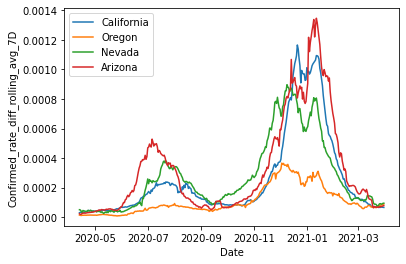

In [33]:
# plot confirmed case numbers for CA and adjacent states
plot_states_over_time(processed_data, ['California','Oregon','Nevada','Arizona'], 'Confirmed_rate_diff_rolling_avg_7D')

Save all the data into a large dataframe for exporting. 

In [34]:
processed_data.to_csv('../data/processed_us_daily_reports.csv')